# Исследование выручки с тарифных планов
____
### В данном исследовании проанализированны траты пользователей по двум тарифным планам оператора сотовой связи «Мегалайн»  - «Ультра» и «Смарт». <a class="tocSkip">
____
##### Есть ли различия в поведении пользователей тарифов, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц, какова выручка, есть ли разница между Москвой и другими регионами, и, главное, какой тариф выгоднее для оператора. Входные данные - небольшая выборка клиентов - данные 500 пользователей «Мегалайна». <a class="tocSkip">

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-файлов-данных-" data-toc-modified-id="Изучение-файлов-данных--1">Изучение файлов данных <a id="step_1"></a></a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-и-подготовка-данных" data-toc-modified-id="Предобработка-и-подготовка-данных-2">Предобработка и подготовка данных</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-2.0.1">Предобработка</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2.0.2">Подготовка</a></span></li><li><span><a href="#Описание-тарифов" data-toc-modified-id="Описание-тарифов-2.0.3">Описание тарифов</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1">Вывод</a></span></li></ul></li><li><span><a href="#Анализ-поведения-клиентов" data-toc-modified-id="Анализ-поведения-клиентов-3">Анализ поведения клиентов</a></span><ul class="toc-item"><li><span><a href="#План" data-toc-modified-id="План-3.1">План</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2">Вывод</a></span></li></ul></li><li><span><a href="#Проверка-гипотез-о-разнице-тарифов" data-toc-modified-id="Проверка-гипотез-о-разнице-тарифов-4">Проверка гипотез о разнице тарифов</a></span><ul class="toc-item"><li><span><a href="#План" data-toc-modified-id="План-4.1">План</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2">Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5">Общий вывод</a></span></li></ul></div>

## Изучение файлов данных <a id='step_1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from scipy import stats as st

%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
calls.sample(10)

,id,call_date,duration,user_id
122618,1317_127,2018-12-14,0.000,1317
52636,1132_229,2018-11-20,1.020,1132
35364,1088_166,2018-08-23,11.300,1088
84986,1213_32,2018-10-19,11.230,1213
49606,1123_625,2018-10-08,18.650,1123
43234,1109_209,2018-02-25,6.960,1109
31624,1078_968,2018-08-07,12.080,1078
145899,1372_77,2018-05-20,6.030,1372
48042,1120_143,2018-10-15,5.000,1120
103120,1264_259,2018-10-01,9.890,1264


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.duplicated().sum()

0

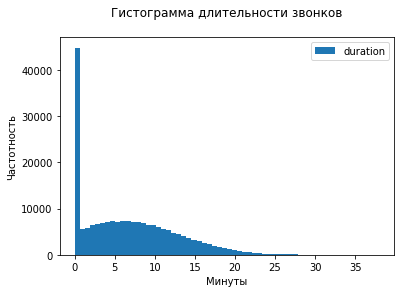

In [6]:
calls.plot(kind='hist', y='duration', bins=60)
plt.title('Гистограмма длительности звонков'+ "\n")
plt.xlabel('Минуты')
plt.ylabel('Частотность')

plt.show()

In [7]:
calls['duration'].value_counts().sort_index()[0] / len(calls)

0.19551644316336553

In [8]:
calls[calls['duration'] < 0.1]['duration'].value_counts()

0.000    39613
0.010      101
0.070       88
0.040       85
0.020       84
0.060       80
0.030       80
0.080       77
0.050       77
0.090       70
Name: duration, dtype: int64

In [9]:
calls[calls['duration'] == 0]['user_id'].value_counts()

1377    336
1168    308
1453    295
1375    290
1196    262
       ... 
1397      6
1442      5
1424      5
1084      5
1406      5
Name: user_id, Length: 492, dtype: int64

Данные о звонках: айди звонка, дата звонка, длительность звонка в минутах, айди юзера совершившего звонок.
- данные о дате звонка нужно привести к правильному типу;
- о нулевых значениях в длительности (19,55%) нужно сообщить, это могут быть как необозначенные тарифные опции (любимый номер и т.д.), так и недозвоны и сброшенные гудки, чтобы перезвонили или обратили внимание на сообщения, их можно дополнительно изучить, как модель поведения пользователя, но в рамках этого исследования для подсчёта выручки с пользователей заменять их не буду, сброшу;
- добавить столбец с целочисленными округленными вверх значениями длительности для подсчёта выручки;
- добавить столбец с категорией месяца;
- дубликатов нет;
- пропусков нет.

In [10]:
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
78099,78099,1263_170,568.570,2018-12-06,1263
134313,134313,1451_41,432.260,2018-11-25,1451
50149,50149,1172_431,322.190,2018-08-28,1172
59445,59445,1200_275,231.530,2018-07-12,1200
17330,17330,1059_336,0.000,2018-08-03,1059
13477,13477,1046_9,451.260,2018-11-24,1046
47740,47740,1164_309,1046.590,2018-07-20,1164
94,94,1000_94,107.630,2018-08-07,1000
28944,28944,1101_50,0.000,2018-09-17,1101
15935,15935,1055_393,662.130,2018-03-29,1055


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [12]:
internet.duplicated().sum()

0

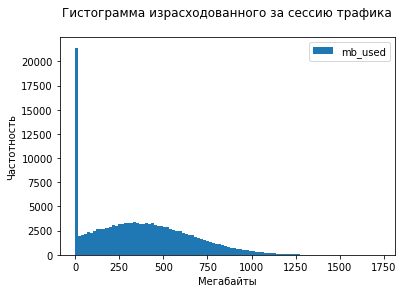

In [13]:
internet.plot(kind='hist', y='mb_used', bins=100)
plt.title('Гистограмма израсходованного за сессию трафика'+ "\n")
plt.xlabel('Мегабайты')
plt.ylabel('Частотность')

plt.show()

In [14]:
internet['mb_used'].value_counts().sort_index()[0] / len(internet)

0.13118155773916304

In [15]:
internet[internet['mb_used'] < 1]['mb_used'].value_counts()

0.000    19598
0.410        6
0.520        4
0.170        3
0.860        3
         ...  
0.850        1
0.820        1
0.800        1
0.110        1
0.680        1
Name: mb_used, Length: 63, dtype: int64

In [16]:
internet[internet['mb_used'] == 0]['user_id'].value_counts()

1204    144
1496    141
1429    125
1119    124
1227    121
       ... 
1084      1
1461      1
1309      1
1201      1
1016      1
Name: user_id, Length: 494, dtype: int64

Данные об интернет-сессиях: айди сессии, израсходованный за сессию трафик, дата сессии, айди юзера.
- удалить столбец дублирующий индекс;
- данные о дате сессии нужно привести к правильному типу;
- о сессиях с нулевым трафиком (13,12%) нужно сообщить, это могут быть как необозначенные тарифные опции (бесплатный трафик в соцсетях и т.д.), так и ошибки конекта, в рамках этого исследования для подсчёта выручки с пользователей заменять их не буду, сброшу;
- добавить столбец с целочисленными округленными вверх значениями израсходованного за сессию трафика для подсчёта выручки;
- добавить столбец с категорией месяца;
- дубликатов нет;
- пропусков нет.

In [17]:
messages.sample(10)

,id,message_date,user_id
75139,1318_168,2018-03-29,1318
60923,1268_238,2018-11-28,1268
61906,1272_59,2018-10-31,1272
99327,1405_17,2018-10-13,1405
29723,1130_98,2018-06-27,1130
79745,1333_101,2018-09-28,1333
52788,1232_25,2018-10-28,1232
89323,1373_335,2018-07-25,1373
17829,1079_7,2018-09-29,1079
11399,1048_45,2018-09-14,1048


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
messages.duplicated().sum()

0

Данные о сообщениях: айди сообщения, дата сообщения, айди юзера.
- данные о дате сообщения нужно привести к правильному типу;
- добавить столбец с категорией месяца;
- дубликатов нет;
- пропусков нет.

In [20]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Данные о тарифах: колличество включённых в тариф - сообщений, мегабайт месячного трафика и минут звонков, ежемесячная плата, стоимость гигабайтов, сообщений и минут сверх тарифа, названия тарифов.

In [22]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
429,1429,54,NaN,Санкт-Петербург,Джулия,Белякова,2018-01-26,smart
445,1445,40,NaN,Москва,Рауль,Иванов,2018-12-29,smart
323,1323,67,NaN,Челябинск,Эсмеральда,Носкова,2018-08-02,smart
475,1475,40,NaN,Новокузнецк,Лидия,Фадеева,2018-01-09,smart
456,1456,40,NaN,Санкт-Петербург,Мануэла,Андропова,2018-08-25,smart
487,1487,72,NaN,Кострома,Рудольф,Кириллов,2018-08-13,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
413,1413,37,NaN,Новосибирск,Леон,Фролов,2018-08-19,smart
52,1052,52,NaN,Санкт-Петербург,Павел,Панов,2018-07-27,smart
410,1410,25,NaN,Нижний Тагил,Гарри,Ильин,2018-08-28,smart


In [23]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [24]:
users.duplicated().sum()

0

Данные о пользователях: айди, возраст, дата прекращения пользования тарифом, город, имя, фамилия, дата подключения тарифа, тариф.
- данные о дате подключения тарифа и прекращения пользования тарифом нужно привести к правильному типу;
- дубликатов нет;
- пропуски в дате прекращения пользования тарифом - тариф действовал на момент выгрузки данных; 38 абонентов отказались от тарифов, стоило бы изучить причины отказа.

### Вывод
Данные не требуют глубокой предобработки, но оставляют ряд вопросов к заказчику.

## Предобработка и подготовка данных

#### Предобработка
Данные о звонках:
- привести данные о дате звонка к правильному типу;
- сбросить строки с нулевыми значениями в длительности;
- добавить столбец с целочисленными округленными вверх значениями длительности для подсчёта выручки;
- добавить столбец с категорией месяца.

Данные об интернет-сессиях:
- удалить столбец дублирующий индекс;
- привести данные о дате сессии нужно к правильному типу;
- сбросить строки с нулевым трафиком;
- добавить столбец с целочисленными округленными вверх значениями израсходованного за сессию трафика для подсчёта выручки;
- добавить столбец с категорией месяца.

Данные о сообщениях:
- привести данные о дате сообщения к правильному типу;
- добавить столбец с категорией месяца.

Данные о пользователях:
- привести данные о датах подключения тарифа и прекращения пользования тарифом к правильному типу.

In [25]:
display(calls.sample(10))
calls.info()

,id,call_date,duration,user_id
42340,1104_242,2018-09-15,7.200,1104
41490,1101_533,2018-11-10,3.030,1101
15043,1040_42,2018-12-02,0.000,1040
185350,1458_642,2018-10-22,0.000,1458
182083,1453_1275,2018-01-24,2.930,1453
113000,1290_178,2018-07-15,11.780,1290
100000,1254_430,2018-04-03,0.000,1254
134878,1344_695,2018-04-13,9.160,1344
79249,1197_241,2018-06-24,18.580,1197
142444,1360_887,2018-10-25,4.300,1360


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [26]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [27]:
calls = calls[calls['duration'] != 0].reset_index()

In [28]:
calls['duration_round'] = np.ceil(calls['duration']).astype('int')

In [29]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [30]:
calls = calls.drop('index', axis=1)

In [31]:
display(calls.sample(10))
calls.info()

,id,call_date,duration,user_id,duration_round,month
131743,1402_605,2018-11-29,14.310,1402,15,11
114055,1360_367,2018-10-25,3.240,1360,4,10
33960,1104_180,2018-07-16,22.720,1104,23,7
99200,1318_447,2018-04-11,9.580,1318,10,4
122704,1380_288,2018-11-25,19.970,1380,20,11
110781,1352_519,2018-11-27,11.000,1352,11,11
159422,1486_42,2018-12-16,25.810,1486,26,12
9336,1030_162,2018-11-05,20.090,1030,21,11
96443,1310_203,2018-08-24,10.500,1310,11,8
147042,1454_647,2018-12-07,5.600,1454,6,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              162994 non-null  object        
 1   call_date       162994 non-null  datetime64[ns]
 2   duration        162994 non-null  float64       
 3   user_id         162994 non-null  int64         
 4   duration_round  162994 non-null  int32         
 5   month           162994 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 6.8+ MB


In [32]:
display(internet.sample(10))
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
83389,83389,1282_463,315.910,2018-03-28,1282
2647,2647,1009_289,0.000,2018-11-04,1009
36062,36062,1126_9,566.990,2018-11-05,1126
52127,52127,1176_282,384.780,2018-10-13,1176
148676,148676,1496_624,346.680,2018-07-27,1496
37268,37268,1130_166,465.840,2018-08-13,1130
100171,100171,1337_208,714.020,2018-10-12,1337
83306,83306,1282_380,391.600,2018-10-22,1282
109723,109723,1373_645,107.920,2018-09-01,1373
133420,133420,1446_203,170.220,2018-09-03,1446


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [33]:
internet = internet.drop('Unnamed: 0', axis=1)

In [34]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [35]:
internet = internet[internet['mb_used'] != 0].reset_index()

In [36]:
internet['mb_used_round'] = np.ceil(internet['mb_used']).astype('int')

In [37]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [38]:
internet = internet.drop('index', axis=1)

In [39]:
display(internet.sample(10))
internet.info()

,id,mb_used,session_date,user_id,mb_used_round,month
98036,1381_558,442.860,2018-09-18,1381,443,9
102109,1395_240,504.390,2018-06-11,1395,505,6
13362,1055_138,111.810,2018-07-29,1055,112,7
6402,1025_411,440.830,2018-05-15,1025,441,5
107103,1414_346,80.980,2018-06-30,1414,81,6
115066,1440_169,732.870,2018-08-21,1440,733,8
126055,1483_396,338.090,2018-11-11,1483,339,11
41686,1168_113,1249.710,2018-08-31,1168,1250,8
59941,1238_131,385.580,2018-09-11,1238,386,9
69698,1272_81,176.850,2018-12-17,1272,177,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             129798 non-null  object        
 1   mb_used        129798 non-null  float64       
 2   session_date   129798 non-null  datetime64[ns]
 3   user_id        129798 non-null  int64         
 4   mb_used_round  129798 non-null  int32         
 5   month          129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 5.4+ MB


In [40]:
display(messages.sample(10))
messages.info()

,id,message_date,user_id
66995,1285_183,2018-07-31,1285
28761,1124_224,2018-12-28,1124
115060,1471_288,2018-08-02,1471
94202,1385_911,2018-05-02,1385
41739,1176_490,2018-04-04,1176
26126,1109_2,2018-03-04,1109
25208,1104_400,2018-04-06,1104
43580,1188_43,2018-03-10,1188
118722,1482_284,2018-09-24,1482
96030,1395_17,2018-07-18,1395


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [41]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [42]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [43]:
display(messages.sample(10))
messages.info()

,id,message_date,user_id,month
50463,1226_139,2018-12-05,1226,12
29674,1130_49,2018-12-21,1130,12
96571,1396_222,2018-11-22,1396,11
54010,1239_75,2018-06-14,1239,6
35894,1155_283,2018-05-29,1155,5
14777,1065_113,2018-05-03,1065,5
47893,1212_204,2018-12-22,1212,12
104618,1424_471,2018-08-22,1424,8
109817,1440_758,2018-12-03,1440,12
21227,1089_1230,2018-09-16,1089,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


In [44]:
display(users.sample(10))
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
109,1109,64,NaN,Санкт-Петербург,Екатерина,Андрющенко,2018-02-23,smart
40,1040,23,NaN,Сочи,Юрий,Одинцов,2018-06-08,smart
386,1386,21,NaN,Новосибирск,Фаддей,Родионов,2018-08-13,smart
29,1029,51,NaN,Екатеринбург,Алексей,Селезнев,2018-09-15,smart
25,1025,56,NaN,Уфа,Матвей,Акинин,2018-03-15,smart
391,1391,47,NaN,Стерлитамак,Герасим,Аркадьев,2018-05-12,ultra
422,1422,60,2018-12-21,Москва,Клара,Устинова,2018-10-12,smart
367,1367,43,2018-11-16,Москва,Всеволод,Антоненко,2018-09-14,ultra
114,1114,53,NaN,Пермь,Маргарита,Колесова,2018-07-26,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [45]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [46]:
display(users.sample(10))
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
488,1488,47,NaT,Новороссийск,Вадим,Филатов,2018-11-07,smart
153,1153,59,NaT,Ульяновск,Евдокия,Одинцова,2018-10-18,smart
72,1072,49,NaT,Уфа,Андрей,Андрейкин,2018-02-20,smart
402,1402,23,NaT,Пенза,Мариетта,Измайлова,2018-03-09,ultra
482,1482,68,NaT,Санкт-Петербург,Алина,Блохина,2018-02-28,smart
311,1311,33,NaT,Тверь,Лолита,Крылова,2018-08-03,smart
49,1049,41,NaT,Москва,Габриель,Ларин,2018-03-10,ultra
456,1456,40,NaT,Санкт-Петербург,Мануэла,Андропова,2018-08-25,smart
373,1373,34,NaT,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart
199,1199,27,NaT,Чебоксары,Агата,Демьянова,2018-09-10,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


#### Подготовка
Посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

In [47]:
calls_pivot1 = calls.pivot_table(index=['user_id', 'month'], values='duration_round', aggfunc=['count', 'sum']).reset_index()
calls_pivot1.columns = ['user_id', 'month', 'calls_count', 'calls_round_sum']
calls_pivot2 = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()
calls_pivot2.columns = ['user_id', 'month', 'calls_sum']
calls_pivot = calls_pivot1.merge(calls_pivot2, on=['user_id', 'month'], how='outer')
calls_pivot.sample(10)

,user_id,month,calls_count,calls_round_sum,calls_sum
1246,1197,8,59,497,464.810
1973,1315,12,53,489,465.720
1984,1318,5,67,598,561.090
1524,1244,9,40,338,318.290
491,1078,10,121,1061,999.370
535,1085,11,21,172,160.750
1382,1219,6,51,453,427.380
1141,1180,4,10,76,69.790
2280,1366,9,23,155,143.660
284,1045,10,29,285,267.940


In [48]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_count']
messages_pivot.sample(10)

,user_id,month,messages_count
1409,1274,7,76
1034,1193,11,26
1362,1266,11,43
2083,1393,2,16
1044,1196,12,172
987,1186,11,60
1177,1227,2,27
1701,1326,10,17
1519,1294,12,23
321,1059,7,22


In [49]:
internet_pivot1 = internet.pivot_table(index=['user_id', 'month'], values='mb_used_round', aggfunc='sum').reset_index()
internet_pivot1.columns = ['user_id', 'month', 'mb_round_sum_internet']
internet_pivot2 = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
internet_pivot2.columns = ['user_id', 'month', 'mb_sum_internet']
internet_pivot = internet_pivot1.merge(internet_pivot2, on=['user_id', 'month'], how='outer')
internet_pivot.sample(10)

,user_id,month,mb_round_sum_internet,mb_sum_internet
229,1035,11,11834,11816.840
17,1003,8,8571,8565.210
821,1127,8,18487,18466.940
1542,1243,10,21299,21276.910
2808,1436,9,22592,22574.370
1655,1262,11,26270,26240.780
2347,1373,12,23856,23828.490
87,1011,12,22900,22870.720
342,1055,2,14759,14739.720
3080,1479,12,23455,23425.980


In [50]:
revenue = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
revenue = revenue.merge(internet_pivot, on=['user_id', 'month'], how='outer')
revenue = revenue.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='left')
revenue.sample(10)

,user_id,month,calls_count,calls_round_sum,calls_sum,messages_count,mb_round_sum_internet,mb_sum_internet,city,tariff
2581,1408,9,81.000,750.000,706.120,10.000,14706.000,14688.370,Самара,smart
1430,1227,2,70.000,602.000,566.580,27.000,19727.000,19701.290,Санкт-Петербург,smart
2906,1458,4,94.000,761.000,714.680,4.000,14353.000,14340.830,Барнаул,ultra
2091,1335,7,68.000,602.000,569.210,93.000,16563.000,16546.930,Москва,ultra
1647,1265,6,18.000,142.000,132.880,18.000,9569.000,9561.550,Омск,ultra
895,1145,6,50.000,397.000,373.620,99.000,13006.000,12991.350,Тюмень,smart
3116,1490,12,35.000,290.000,271.630,46.000,15806.000,15785.740,Москва,smart
1856,1296,12,30.000,252.000,238.550,50.000,15355.000,15333.660,Москва,smart
1463,1233,9,73.000,663.000,625.630,27.000,21278.000,21250.980,Воронеж,smart
660,1105,10,42.000,310.000,288.740,70.000,29263.000,29223.070,Улан-Удэ,smart


In [51]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Описание тарифов

**Тариф «Смарт»** 
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [52]:
def monthly_revenue(row):
    """
    Функция по расчету ежемесячной выручки. Опции по тарифам соотносятся с информацией из таблицы tariffs.
    """
    money = 0
    
    tariff = row['tariff']
    calls_sum = row['calls_round_sum']
    messages_count = row['messages_count']
    mb_sum_internet = row['mb_round_sum_internet']
    
    # Считается разница между потраченными минутами, трафиком, смс и объемом услуг, включенных в абонентскую плату
    difference_calls = calls_sum - int(tariffs[tariffs['tariff_name'] == tariff]['minutes_included'])
    difference_messages = messages_count - int(tariffs[tariffs['tariff_name'] == tariff]['messages_included'])
    difference_internet = mb_sum_internet - int(tariffs[tariffs['tariff_name'] == tariff]['mb_per_month_included'])
    
    # Если пользователь вышел за пределы лимитов, обозначенных в абонентской плате, то рассчитывается дополнительная оплата
    if (difference_calls > 0):
        money += difference_calls * int(tariffs[tariffs['tariff_name'] == tariff]['rub_per_minute'])
    if difference_messages > 0:
        money += difference_messages * int(tariffs[tariffs['tariff_name'] == tariff]['rub_per_message'])
    if difference_internet > 0:
        gb_over_tarif = np.ceil(difference_internet / 1024)
        money += gb_over_tarif * int(tariffs[tariffs['tariff_name'] == tariff]['rub_per_gb'])
    
    # Добавление ежемесячной абонентской платы
    money += int(tariffs[tariffs['tariff_name'] == tariff]['rub_monthly_fee'])
    
    return money

In [53]:
revenue['monthly_revenue'] = revenue.apply(monthly_revenue, axis=1)
revenue['monthly_revenue'] = revenue['monthly_revenue'].astype('int')
revenue.sample(10)

,user_id,month,calls_count,calls_round_sum,calls_sum,messages_count,mb_round_sum_internet,mb_sum_internet,city,tariff,monthly_revenue
1270,1201,9,107.000,1045.000,991.190,NaN,12206.000,12196.550,Москва,ultra,1950
1299,1204,12,45.000,416.000,395.320,NaN,23288.000,23259.550,Москва,smart,2150
1006,1160,12,41.000,365.000,345.300,30.000,13579.000,13560.090,Ульяновск,smart,550
2215,1356,9,93.000,866.000,823.580,130.000,29314.000,29289.040,Москва,ultra,1950
2926,1460,12,78.000,671.000,633.240,45.000,14277.000,14256.630,Ижевск,smart,1063
1366,1217,8,70.000,600.000,563.200,86.000,12389.000,12375.170,Ульяновск,smart,958
2315,1373,3,2.000,22.000,20.950,55.000,22653.000,22620.560,Улан-Удэ,smart,2165
1937,1310,6,56.000,483.000,456.440,45.000,17504.000,17489.440,Уфа,ultra,1950
2619,1414,6,43.000,338.000,317.480,52.000,17499.000,17477.070,Владимир,smart,1156
1105,1176,3,50.000,400.000,372.490,47.000,17298.000,17272.690,Волгоград,smart,950


### Вывод
- Данные о датах приведены к типу datetime64.
- Удалены строки с нулевыми значениями в длительности звонков и трафике интернет-сессий.
- Добавлены столбцы с категорией месяца.
- Добавлены столбцы с целочисленными округленными вверх значениями для подсчёта выручки.

Посчитаны для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячная выручка с каждого пользователя.

## Анализ поведения клиентов

###  План
Сколько минут разговора требуется пользователям каждого тарифа в месяц?
- посчитать среднее количество,дисперсию и стандартное отклонение;
- построить гистограмму;
- описать распределения.

Сколько сообщений требуется пользователям каждого тарифа в месяц:
- посчитать среднее количество,дисперсию и стандартное отклонение;
- построить гистограмму;
- описать распределения.

Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц:
- посчитать среднее количество,дисперсию и стандартное отклонение;
- построить гистограмму;
- описать распределения.

In [54]:
def describe_column(column):
    create_pivot = revenue.pivot_table(index='tariff', columns='month', values=column, aggfunc='mean').T
    print(create_pivot.describe())
    print(' ')
    print('Среднее количество для тарифа "Смарт" {:.2f}'.format(create_pivot.mean()[0]))
    print('Среднее количество для тарифа "Ультра" {:.2f}'.format(create_pivot.mean()[1]))
    print('Дисперсия для тарифа "Смарт" {:.2f}'.format(create_pivot.var()[0]))
    print('Дисперсия для тарифа "Ультра" {:.2f}'.format(create_pivot.var()[1]))
    print('Стандартное отклонение для тарифа "Смарт" {:.2f}'.format(create_pivot.std()[0]))
    print('Стандартное отклонение для тарифа "Ультра" {:.2f}'.format(create_pivot.std()[1]))

In [55]:
describe_column('calls_sum')

tariff   smart   ultra
count   12.000  12.000
mean   366.627 484.936
std     67.015  77.901
min    198.892 292.770
25%    361.246 458.817
50%    380.490 504.932
75%    404.255 533.928
max    453.041 580.510
 
Среднее количество для тарифа "Смарт" 366.63
Среднее количество для тарифа "Ультра" 484.94
Дисперсия для тарифа "Смарт" 4491.03
Дисперсия для тарифа "Ультра" 6068.60
Стандартное отклонение для тарифа "Смарт" 67.02
Стандартное отклонение для тарифа "Ультра" 77.90


In [56]:
print('Доля среднего от тарифного пакета "Смарт" {:.2f}'.format(revenue.pivot_table(index='tariff', columns='month', values='calls_sum', aggfunc='mean').T.mean()[0] / 500 * 100))
print('Доля среднего от тарифного пакета "Ультра" {:.2f}'.format(revenue.pivot_table(index='tariff', columns='month', values='calls_sum', aggfunc='mean').T.mean()[1] / 3000 * 100))

Доля среднего от тарифного пакета "Смарт" 73.33
Доля среднего от тарифного пакета "Ультра" 16.16


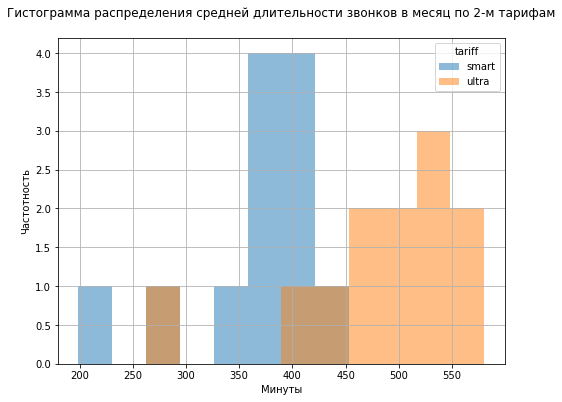

In [57]:
(revenue
 .pivot_table(index='tariff', columns='month', values='calls_sum', aggfunc='mean')
 .T
 .plot(kind='hist', alpha=0.5, bins=12, grid=True, figsize = (8,6))
)
plt.title('Гистограмма распределения средней длительности звонков в месяц по 2-м тарифам'+ "\n")
plt.xlabel('Минуты')
plt.ylabel('Частотность')

plt.show()

Средняя длительность разговоров у абонентов тарифа "Ультра" больше, чем у абонентов тарифа "Смарт". Распределение обоих тарифов скошено влево. Абоненты тарифа "Смарт" используют в среднем три четверти своего тарифного пакет минут, тогда как абоненты тарифа "Ультра" меньше одной пятой.

In [58]:
describe_column('messages_count')

tariff  smart  ultra
count  12.000 12.000
mean   36.263 55.170
std     6.230 12.043
min    20.000 32.938
25%    35.786 46.978
50%    38.869 55.606
75%    39.117 64.011
max    42.265 72.009
 
Среднее количество для тарифа "Смарт" 36.26
Среднее количество для тарифа "Ультра" 55.17
Дисперсия для тарифа "Смарт" 38.81
Дисперсия для тарифа "Ультра" 145.02
Стандартное отклонение для тарифа "Смарт" 6.23
Стандартное отклонение для тарифа "Ультра" 12.04


In [59]:
print('Доля среднего от тарифного пакета "Смарт" {:.2f}'.format(revenue.pivot_table(index='tariff', columns='month', values='messages_count', aggfunc='mean').T.mean()[0] / 50 * 100))
print('Доля среднего от тарифного пакета "Ультра" {:.2f}'.format(revenue.pivot_table(index='tariff', columns='month', values='messages_count', aggfunc='mean').T.mean()[1] / 1000 * 100))

Доля среднего от тарифного пакета "Смарт" 72.53
Доля среднего от тарифного пакета "Ультра" 5.52


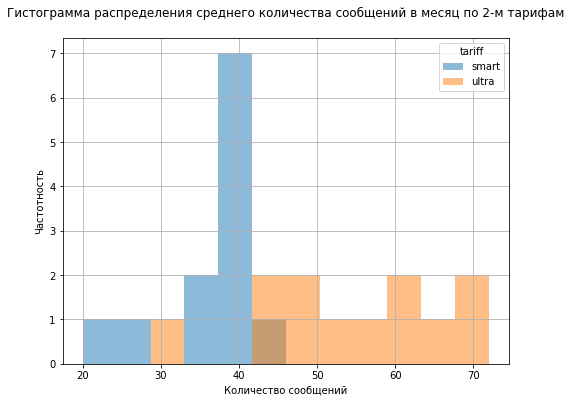

In [60]:
(revenue
 .pivot_table(index='tariff', columns='month', values='messages_count', aggfunc='mean')
 .T
 .plot(kind='hist', alpha=0.5, bins=12, grid=True, figsize = (8,6))
)
plt.title('Гистограмма распределения среднего количества сообщений в месяц по 2-м тарифам'+ "\n")
plt.xlabel('Количество сообщений')
plt.ylabel('Частотность')

plt.show()

Cреднее количество сообщений у абонентов тарифа "Ультра" больше, чем у абонентов тарифа "Смарт". Для описания  распределения обоих тарифов недостаточно данных. Абоненты тарифа "Смарт" используют в среднем около трёх четвертей своего тарифного пакет сообщений, тогда как абоненты тарифа "Ультра" чуть больше одной двадцатой.

In [61]:
revenue.sample(10)

,user_id,month,calls_count,calls_round_sum,calls_sum,messages_count,mb_round_sum_internet,mb_sum_internet,city,tariff,monthly_revenue
2977,1468,12,27.000,216.000,201.530,11.000,14929.000,14912.410,Тамбов,smart,550
1577,1252,12,53.000,532.000,506.360,20.000,17741.000,17713.510,Ростов-на-Дону,smart,1246
1649,1265,8,96.000,814.000,764.820,81.000,37321.000,37285.850,Омск,ultra,3000
561,1089,7,45.000,417.000,396.420,152.000,16152.000,16139.090,Иркутск,ultra,1950
2169,1346,12,111.000,869.000,814.700,50.000,4700.000,4694.600,Саратов,ultra,1950
1160,1183,12,69.000,564.000,526.180,46.000,16044.000,16021.730,Владивосток,smart,942
2801,1439,10,54.000,452.000,424.220,10.000,17009.000,16983.500,Орёл,smart,950
1066,1171,11,79.000,715.000,673.920,78.000,16311.000,16290.860,Москва,smart,1479
2313,1372,12,63.000,515.000,484.930,36.000,16622.000,16599.480,Магнитогорск,smart,995
1341,1212,12,59.000,443.000,413.250,129.000,21762.000,21735.070,Саранск,smart,2187


In [62]:
describe_column('mb_sum_internet')

tariff     smart     ultra
count     12.000    12.000
mean   15069.088 18451.327
std     2678.367  2878.206
min     8513.718 12846.477
25%    14693.664 17358.696
50%    15799.916 19566.735
75%    16714.858 20021.618
max    18113.662 21951.094
 
Среднее количество для тарифа "Смарт" 15069.09
Среднее количество для тарифа "Ультра" 18451.33
Дисперсия для тарифа "Смарт" 7173651.37
Дисперсия для тарифа "Ультра" 8284071.33
Стандартное отклонение для тарифа "Смарт" 2678.37
Стандартное отклонение для тарифа "Ультра" 2878.21


In [63]:
print('Доля среднего от тарифного пакета "Смарт" {:.2f}'.format(revenue.pivot_table(index='tariff', columns='month', values='mb_sum_internet', aggfunc='mean').T.mean()[0] / 15360 * 100))
print('Доля среднего от тарифного пакета "Ультра" {:.2f}'.format(revenue.pivot_table(index='tariff', columns='month', values='mb_sum_internet', aggfunc='mean').T.mean()[1] / 30720 * 100))

Доля среднего от тарифного пакета "Смарт" 98.11
Доля среднего от тарифного пакета "Ультра" 60.06


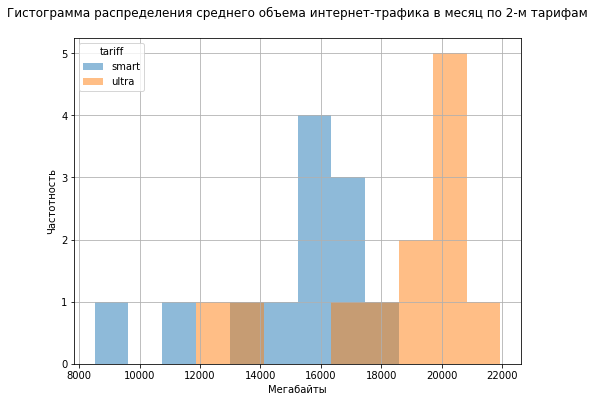

In [64]:
(revenue
 .pivot_table(index='tariff', columns='month', values='mb_sum_internet', aggfunc='mean')
 .T
 .plot(kind='hist', alpha=0.5, bins=12, grid=True, figsize = (8,6))
)
plt.title('Гистограмма распределения среднего объема интернет-трафика в месяц по 2-м тарифам'+ "\n")
plt.xlabel('Мегабайты')
plt.ylabel('Частотность')

plt.show()

Cредний объём интернет-трафика у абонентов тарифа "Ультра" больше, чем у абонентов тарифа "Смарт". Распределение обоих тарифов скошено влево. Абоненты тарифа "Смарт" используют в среднем практически весь тарифный пакет, тогда как абоненты тарифа "Ультра" немного меньше двух третей.

### Вывод
В среднем ежемесячно пользователи тарифа "Ультра" потребляют больший объём услуг в абсолютном выражении. НО! Относительно пакета оплачиваемых услуг, они сильно уступают абонентам тарифа "Смарт".
В итоге, для оператора тариф "Ультра" может быть выгоднее тарифа "Смарт", так как ему значительно реже придётся предоставлять оплаченные услуги в полном объёме.

## Проверка гипотез о разнице тарифов

###  План
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:
- формулировка гипотезы
- проверка.

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
- формулировка гипотезы
- проверка.

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Н0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **равны**, т.е. средние значения равны.

Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **не равны**, т.е. средние значения не равны.

Для проверки гипотезы будет использоваться критерий p-value. 

In [65]:
sample_1 = revenue[revenue['tariff'] == 'ultra']['monthly_revenue'] 
sample_2 = revenue[revenue['tariff'] == 'smart']['monthly_revenue'] 
results = st.ttest_ind( sample_1, sample_2)
alpha = 0.05

print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-value:  2.9776448000521676e-158
Принимаем альтернативную гипотезу


Столь малое p-value позволяет с высокой вероятностью положится на результаты исследования и принять гипотезу и серьёхных различиях в выручке тарифов.

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Н0 - средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов, т.е. средние значения равны.

Н1 - средняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов, т.е. средние значения не равны.

Для проверки гипотезы будет использоваться критерий p-value. 

In [66]:
sample_1 = revenue[revenue['city'] == 'Москва']['monthly_revenue'] 
sample_2 = revenue[revenue['city'] != 'Москва']['monthly_revenue'] 
results = st.ttest_ind( sample_2,
sample_1)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-значение:  0.531666503831252
Опровергнуть нулевую гипотезу нельзя


Полученное p-value не позволяет опровергнуть нулевую гипотезу, перевес в сторону Москвы слишком мал, чтобы утверждать о различиях в выручке.

### Вывод
Результаты проверки гипотезы о различиях в тарифах позволяют говорить о малой вероятности случайности результатов исследования. В свою очередь для проверки гипотезы о различии столицы и провинций нужно больше данных.

## Общий вывод
В среднем ежемесячно пользователи тарифа "Ультра" потребляют больший объём услуг в абсолютном выражении. НО! Относительно пакета оплачиваемых услуг, они сильно уступают абонентам тарифа "Смарт". В итоге, для оператора тариф "Ультра" может быть выгоднее тарифа "Смарт", так как ему значительно реже придётся предоставлять оплаченные услуги в полном объёме.
Результаты проверки гипотезы о различиях в тарифах позволяют говорить о малой вероятности случайности результатов исследования.

**Считаю наиболее выгодным для оператора расширение пользовательской базы тарифа "Ультра".**